In [26]:
# 🔹 1. Import Libraries
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix



In [27]:
# 🔹 2. Load Datasets
Dataset_Train = pd.read_csv('C:/Users/Asus/Downloads/archive (5)/train_data.csv')
Dataset_Test = pd.read_csv('C:/Users/Asus/Downloads/archive (5)/test_data.csv')


🔹 Class Distribution in Training Set

Class Counts:
 health_condition
healthy         1711
Hypertension     347
Diabetes         226
Asthma           116
Name: count, dtype: int64

Class Percentages (%):
 health_condition
healthy         71.29
Hypertension    14.46
Diabetes         9.42
Asthma           4.83
Name: proportion, dtype: float64


C:\Users\Asus\AppData\Local\Temp\ipykernel_21048\243373770.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='health_condition', data=Dataset_Train, palette='Set2')


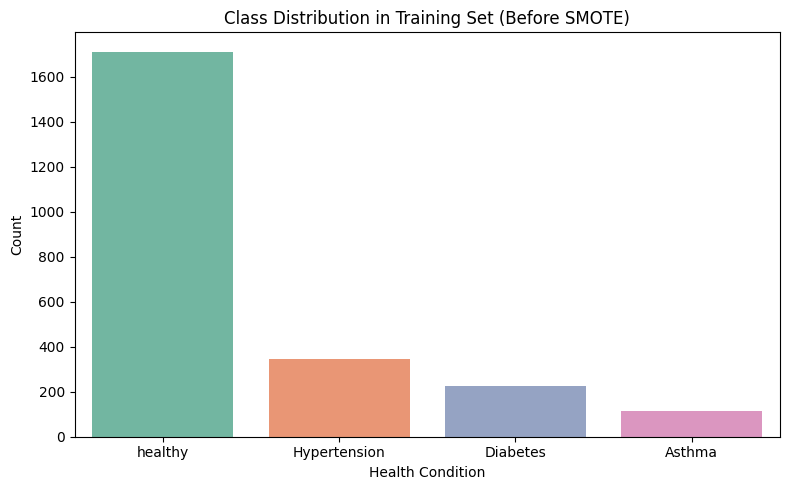

In [28]:
# 🔹 3. Class Distribution (Before SMOTE)
# =====================================
print("🔹 Class Distribution in Training Set")

class_counts = Dataset_Train['health_condition'].value_counts()
class_percentages = Dataset_Train['health_condition'].value_counts(normalize=True) * 100

print("\nClass Counts:\n", class_counts)
print("\nClass Percentages (%):\n", class_percentages.round(2))

plt.figure(figsize=(8, 5))
sns.countplot(x='health_condition', data=Dataset_Train, palette='Set2')
plt.title("Class Distribution in Training Set (Before SMOTE)")
plt.xlabel("Health Condition")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


In [29]:
# 🔹 4. Split Features and Target
# =====================================
X = Dataset_Train.drop(columns=['health_condition'])
y = Dataset_Train['health_condition']



In [30]:
# 🔹 5. Identify Column Types
# =====================================
numeric_cols = X.select_dtypes(include=['number']).columns.tolist()
categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()


In [31]:
# 🔹 6. Preprocessing Pipeline
# =====================================
preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numeric_cols),
    ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_cols)
])

# Fit-transform training data
X_processed = preprocessor.fit_transform(X)



 Dataset is imbalanced. Applying SMOTE...

 Class Distribution After SMOTE:
health_condition
healthy         1711
Hypertension    1711
Diabetes        1711
Asthma          1711
Name: count, dtype: int64


C:\Users\Asus\AppData\Local\Temp\ipykernel_21048\1777842159.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_resampled, palette='Set3')


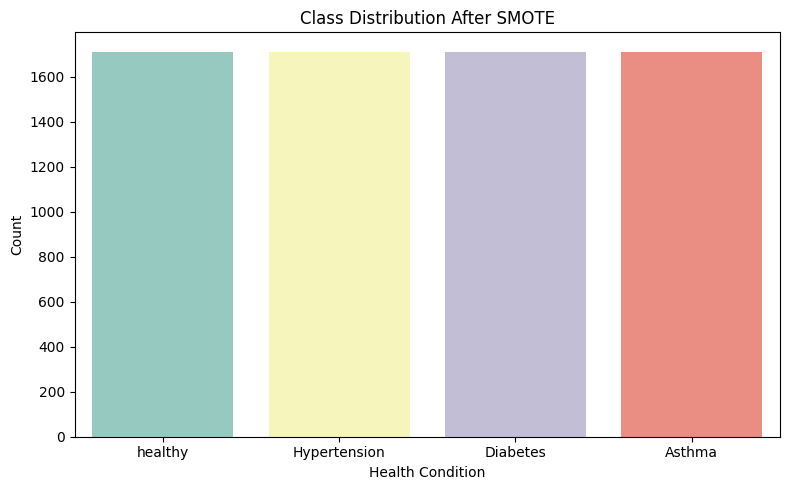

In [32]:
# 🔹 7. Apply SMOTE Only if Imbalanced
# =====================================
imbalance_threshold = 0.1  # if any class <10% of total
minority_ratio = (class_percentages.min()) / 100  # ensure variable defined

if minority_ratio < imbalance_threshold:
    print("\n Dataset is imbalanced. Applying SMOTE...")
    smote = SMOTE(random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X_processed, y)

    print("\n Class Distribution After SMOTE:")
    print(pd.Series(y_resampled).value_counts())

    plt.figure(figsize=(8, 5))
    sns.countplot(x=y_resampled, palette='Set3')
    plt.title("Class Distribution After SMOTE")
    plt.xlabel("Health Condition")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()
else:
    print("\n Dataset is balanced. No need for SMOTE.")
    X_resampled, y_resampled = X_processe

In [33]:
# 🔹 8. Label Encode Target
# =====================================
le = LabelEncoder()
y_resampled_encoded = le.fit_transform(y_resampled)

# Prepare test data
X_test = Dataset_Test.drop(columns=['health_condition'])
y_test = Dataset_Test['health_condition']
X_test_processed = preprocessor.transform(X_test)
y_test_encoded = le.transform(y_test)


In [34]:
# 🔹 9. Train Multinomial Logistic Regression
# =====================================
#multi_log_reg = LogisticRegression(
 #   multi_class='multinomial',  # Explicitly multinomial
  #  solver='lbfgs',             # Works well for multinomial
   # max_iter=2000,              # Increase for convergence
    #random_state=42
#)

multi_log_reg = LogisticRegression(
    solver='lbfgs',
    max_iter=2000,
    random_state=42
)

multi_log_reg.fit(X_resampled, y_resampled_encoded)



,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,42
,solver,'lbfgs'
,max_iter,2000
,multi_class,'deprecated'


In [35]:
# =====================================
# 🔹 10. Predict and Evaluate
# =====================================
y_train_pred_encoded = multi_log_reg.predict(X_resampled)
y_test_pred_encoded = multi_log_reg.predict(X_test_processed)
# Decode predictions
y_train_pred = le.inverse_transform(y_train_pred_encoded)
y_test_pred = le.inverse_transform(y_test_pred_encoded)

print("\n Train Accuracy:", accuracy_score(y_resampled, y_train_pred))
print(" Test Accuracy :", accuracy_score(y_test, y_test_pred))

print("\n🔹 Classification Report (Test Data):")
print(classification_report(y_test, y_test_pred))


 Train Accuracy: 0.3815020455873758
 Test Accuracy : 0.205

🔹 Classification Report (Test Data):
              precision    recall  f1-score   support

      Asthma       0.04      0.21      0.07        29
    Diabetes       0.10      0.32      0.15        57
Hypertension       0.14      0.26      0.19        87
     healthy       0.72      0.18      0.29       427

    accuracy                           0.20       600
   macro avg       0.25      0.24      0.17       600
weighted avg       0.54      0.20      0.25       600



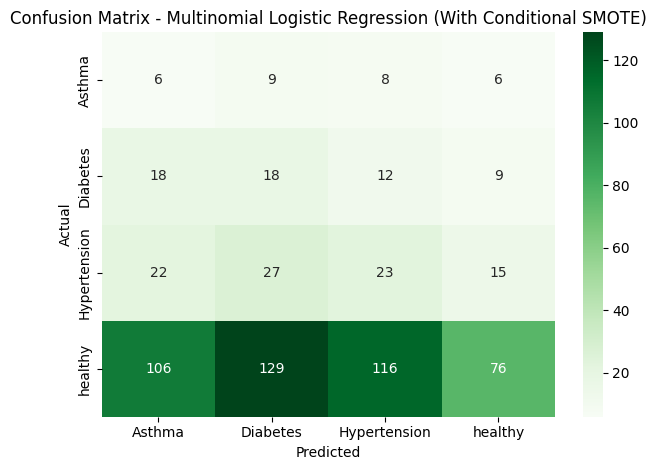

In [36]:
# 🔹 11. Confusion Matrix
# =====================================
cm = confusion_matrix(y_test, y_test_pred, labels=le.classes_)
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Confusion Matrix - Multinomial Logistic Regression (With Conditional SMOTE)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()
